# Objectives

## Create a NAS Model Capable of Constructing a Neural Network to Predict Housing Prices

In [309]:
import torch
from torch import nn
from torch import optim
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision.utils import save_image

from torchsummary import summary

import os

from tqdm import tqdm

import itertools

#### Data

In [10]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection import train_test_split

In [11]:
df = pd.read_csv("data/housepricedata.csv")

In [12]:
df

,LotArea,OverallQual,OverallCond,TotalBsmtSF,FullBath,HalfBath,BedroomAbvGr,TotRmsAbvGrd,Fireplaces,GarageArea,AboveMedianPrice
0,8450,7,5,856,2,1,3,8,0,548,1
1,9600,6,8,1262,2,0,3,6,1,460,1
2,11250,7,5,920,2,1,3,6,1,608,1
3,9550,7,5,756,1,0,3,7,1,642,0
4,14260,8,5,1145,2,1,4,9,1,836,1
...,...,...,...,...,...,...,...,...,...,...,...
1455,7917,6,5,953,2,1,3,7,1,460,1
1456,13175,6,6,1542,2,0,3,7,2,500,1
1457,9042,7,9,1152,2,0,4,9,2,252,1
1458,9717,5,6,1078,1,0,2,5,0,240,0


In [111]:
class HouseDataset(Dataset):

    def __init__(self, df, train=True, random_state=41):
        
        self.train = train
        
        data = df.values
        min_max_scaler = preprocessing.MinMaxScaler()
        X_scaled = min_max_scaler.fit_transform(data[:,0:10])
        Y = data[:,10]
        X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y, test_size=0.3, random_state=random_state)
        
        self.x_train=torch.tensor(X_train,dtype=torch.float32)
        self.y_train=torch.tensor(Y_train,dtype=torch.float32)
        self.x_test=torch.tensor(X_test,dtype=torch.float32)
        self.y_test=torch.tensor(Y_test,dtype=torch.float32)

    def __len__(self):
        if self.train:
            return len(self.y_train)
        else:
            return len(self.y_test)

    def __getitem__(self,idx):
        if self.train:
            return self.x_train[idx], self.y_train[idx]
        else:
            return self.x_test[idx], self.y_test[idx]


In [113]:
""" THIS IS WRONG!!! FIX IT IF MAKING A DIFFERRENT DATASET """ 
train_dataset = HouseDataset(df, train=True)
test_dataset = HouseDataset(df, train=False)

#### Building NAS Model

In [25]:
class SearchSpace(object):
    def __init__(self, target_classes):
        self.target_classes = target_classes
        self.vocab = self.vocab_dict()
        
    def vocab_dict(self, nodes=None, act_funcs=None):
        if (type(nodes) != list) or (nodes == None):
            nodes = [8, 16, 32, 64, 128, 256, 512]
        if (type(act_funcs) != list) or (act_funcs == None):
            act_funcs = ['sigmoid', 'tanh', 'relu', 'elu']
        
        layer_params = []
        layer_id = []

        # for all activation functions for each node
        for i in range(len(nodes)):
            for j in range(len(act_funcs)):

                # create an id and a configuration tuple (node, activation)
                layer_params.append((nodes[i], act_funcs[j]))
                layer_id.append(len(act_funcs) * i + j + 1)

        # zip the id and configurations into a dictionary
        vocab = dict(zip(layer_id, layer_params))
        vocab[len(vocab) + 1] = (('dropout'))
        
        if self.target_classes == 2:
            vocab[len(vocab) + 1] = (self.target_classes - 1, 'sigmoid')
        else:
            vocab[len(vocab) + 1] = (self.target_classes, 'softmax')
        
        return vocab
    
    def encode_sequence(self, sequence):
        keys = list(self.vocab.keys())
        values = list(self.vocab.values())
        encoded_sequence = []
        for value in sequence:
            encoded_sequence.append(keys[values.index(value)])
        return encoded_sequence

    def decode_sequence(self, sequence):
        keys = list(self.vocab.keys())
        values = list(self.vocab.values())
        decoded_sequence = []
        for key in sequence:
            decoded_sequence.append(values[keys.index(key)])
        return decoded_sequence

In [450]:
class GeneratedModel(nn.Module):
    def __init__(self):
        
        super(GeneratedModel, self).__init__()
        
        self.layers = []
        self.nn_layers = nn.ModuleList()
        
    def get_last(self):
        if self.layers[-1][2] != "dropout":
            return self.layers[-1][0].out_features
        else:
            return self.layers[-2][0].out_features
        
    def __lt__(self, other):
        return True
            
        
    def add_layer(self, layer, inp_size, out_size, activation=None):
        if activation == "relu":
            act_func = F.relu
        elif activation == "elu":
            act_func = F.elu
        elif activation == "tanh":
            act_func = F.tanh
        elif activation == "sigmoid":
            act_func = F.sigmoid
        
        if layer == "fc":
            if activation == None:
                raise Exception("Cannot have a fully connected layer without an activation function.")
            self.layers.append((nn.Linear(inp_size, out_size), act_func, "fc"))
            
            if activation == "relu":
                act_func = nn.ReLU()
            elif activation == "elu":
                act_func = nn.ELU()
            elif activation == "tanh":
                act_func = nn.Tanh()
            elif activation == "sigmoid":
                act_func = nn.Sigmoid()
            
            self.nn_layers.append(nn.Linear(inp_size, out_size))
            self.nn_layers.append(act_func)
            
        elif layer == "dropout":
            self.layers.append((nn.Dropout(p=0.25), None, "dropout"))
            self.nn_layers.append(nn.Dropout(p=0.25))
    
    def forward(self, x):
        for layer in self.nn_layers:
            x = layer(x)

        
        return x

In [451]:
test_model = GeneratedModel()

test_model.add_layer("fc", 32, 64, "relu")
test_model.add_layer("fc", 64, 64, "relu")
test_model.add_layer("dropout", 0, 0, None)
test_model.add_layer("fc", 64, 1, "sigmoid")

print(test_model(torch.rand((1, 1, 32))))
print(test_model.layers[0][0].weight.data)

tensor([[[0.4683]]], grad_fn=<SigmoidBackward>)
tensor([[ 0.1312,  0.1045, -0.1188,  ...,  0.0612, -0.0216, -0.0033],
        [ 0.1703, -0.1570,  0.0443,  ...,  0.1112,  0.1379, -0.0240],
        [ 0.1429,  0.0305, -0.0448,  ..., -0.0696, -0.1458, -0.0428],
        ...,
        [-0.1653, -0.0205, -0.1198,  ...,  0.0165,  0.1563, -0.1602],
        [-0.1372, -0.0088, -0.0182,  ..., -0.0096,  0.0617, -0.0553],
        [ 0.0650, -0.0933,  0.0399,  ...,  0.1592, -0.0823,  0.1568]])


In [587]:
class ModelGenerator(SearchSpace):
    def __init__(self):
        self.lr = 0.001
        self.target_classes = 2
        self.optimizer = optim.SGD
        #self.mlp_decay = MLP_DECAY
        #self.mlp_momentum = MLP_MOMENTUM
        self.dropout = False
        self.loss_func = nn.MSELoss()
        self.one_shot = False
        #self.metrics = ['accuracy']
        
        super().__init__(self.target_classes)
        
        if self.one_shot:
            # path to shared weights file 
            self.weights_file = 'LOGS/shared_weights.pkl'

            # open an empty dataframe with columns for bigrams IDs and weights
            self.shared_weights = pd.DataFrame({'bigram_id': [], 'weights': []})

            # pickle the dataframe
            if not os.path.exists(self.weights_file):
                print("Initializing shared weights dictionary...")
                self.shared_weights.to_pickle(self.weights_file)
        
    def create_model(self, sequence, input_shape):
        layer_configs = self.decode_sequence(sequence)
        model = GeneratedModel()
        
        for i, layer_conf in enumerate(layer_configs):
            
            # add the first layer (requires the input shape parameter)
            if i == 0:
                model.add_layer("fc", input_shape, layer_conf[0], layer_conf[1])
                # layer type, input, output (size of layer), activation

            # add subsequent layers (Dense or Dropout)
            elif 'dropout' in layer_conf:
                model.add_layer("dropout", None, None)
            else:
                model.add_layer("fc", model.get_last(), layer_conf[0], layer_conf[1])
                # layer type, input, output (size of layer), activation

        return model
        
    def setup_model(self, model):
        optimizer = self.optimizer(model.parameters(), lr=self.lr)
        criterion = self.loss_func
        return model, optimizer, criterion
    
    def set_model_weights(self, model):
        # get nodes and activations for each layer    
        layer_configs = ['input']
        for layer in model.layers:
            
            if layer[2] == "fc":
                activation = str(layer[1]).split()[1]
                layer_configs.append((layer[0].out_features, activation))


        # get bigrams of relevant layers for weights transfer
        config_ids = []
        for i in range(1, len(layer_configs)):
            config_ids.append((layer_configs[i - 1], layer_configs[i]))

        # for all layers
        j = 0
        for i, layer in enumerate(model.layers):
            if 'dropout' not in layer[2]:
                #warnings.simplefilter(action='ignore', category=FutureWarning)

                # get all bigram values we already have weights for
                bigram_ids = self.shared_weights['bigram_id'].values

                # check if a bigram already exists in the dataframe
                search_index = []
                for i in range(len(bigram_ids)):
                    if config_ids[j] == bigram_ids[i]:
                        search_index.append(i)
                        
                """
                FIX SETTING WEIGHTS
                """

                # set layer weights if there is a bigram match in the dataframe 
                if len(search_index) > 0:
                    #print("Transferring weights for layer:", config_ids[j])
                    layer[0].weight.data = layer[0].weight.data * 0 + self.shared_weights['weights'].values[search_index[0]]
                j += 1
    
    """###############################################"""
                
    def update_weights(self, model):

        # get nodes and activations for each layer
        layer_configs = ['input']
        for layer in model.layers:
            
            if layer[2] == "fc":
                activation = str(layer[1]).split()[1]
                layer_configs.append((layer[0].out_features, activation))

        # get bigrams of relevant layers for weights transfer
        config_ids = []
        for i in range(1, len(layer_configs)):
            config_ids.append((layer_configs[i - 1], layer_configs[i]))

        # for all layers
        j = 0
        for i, layer in enumerate(model.layers):
            if 'dropout' not in layer[2]:
                #warnings.simplefilter(action='ignore', category=FutureWarning)

                #get all bigram values we already have weights for
                bigram_ids = self.shared_weights['bigram_id'].values

                # check if a bigram already exists in the dataframe
                search_index = []
                for i in range(len(bigram_ids)):
                    if config_ids[j] == bigram_ids[i]:
                        search_index.append(i)

                # add weights to df in a new row if weights aren't already available
                if len(search_index) == 0:
                    self.shared_weights = self.shared_weights.append({'bigram_id': config_ids[j],
                                                                      'weights': layer[0].weight.data},
                                                                     ignore_index=True)
                # else update weights 
                else:
                    self.shared_weights.at[search_index[0], 'weights'] = layer[0].weight.data
                j += 1
        self.shared_weights.to_pickle(self.weights_file)

    def train_model(self, model, train_data, epochs, accuracy_fn=None, accuracy_loader=None):
        """ ################## WORK ON ACCURACY_FN ANDD ACCURACY LOADER"""
        model, optim, criterion = self.setup_model(model)
        
        if self.one_shot:
            self.set_model_weights(model)
            
        dataloader = DataLoader(train_data, batch_size=32)
        
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
    
        history = []
        accuracy_history = []
            
        for epoch in range(epochs):
            ### training loop

            model.train()
            running_loss = 0.0
            for bi, data in enumerate(dataloader):
                x = data[0].to(device)
                label = data[1].to(device).view(len(data[1]), 1)

                # zero grad the optimizer
                optim.zero_grad()
                outputs = model(x)
                loss = criterion(outputs, label)
                # backpropagation
                loss.backward()
                # update the parameters
                optim.step()
                # add loss of each item (total items in a batch = batch size)
                running_loss += loss.item()
            final_loss = running_loss/len(dataloader.dataset)
            history.append(final_loss)
            
            if accuracy_fn != None:
                accuracy_history.append(accuracy_fn(accuracy_loader, model))
            
            # testing accuracy on validation set
            
        if self.one_shot:
            self.update_weights(model)
        
        return model, history, accuracy_history

In [588]:
gen = ModelGenerator()

In [589]:
def calculate_accuracy(loader, model):
    num_correct = 0
    num_samples = 0
    model.eval()
    
    with torch.no_grad():
        for x, y in loader:
            x = x.to(device="cpu")
            y = y.to(device="cpu")
            
            scores = model(x)
            predictions = (scores>0.5).float().view(len(y))
            num_correct += (predictions == y).sum()
            num_samples += len(predictions)
        
    model.train()
    return float(num_correct)/float(num_samples)

def build_sequences(generator, dropout=False, hidden_layers=2):
    possible_layers = list(range(1, len(generator.vocab_dict())-2))
    sequences = list(itertools.combinations_with_replacement(possible_layers, 2))
    if dropout:
        
        original_count = len(sequences)
        # doubles length of list to account for added dropout models
        sequences.extend(sequences)
        for i in range(original_count):
            # add dropout to half of layers
            sequences[i] = sequences[i] + (len(generator.vocab_dict())-1,)
    
    for i, seq in enumerate(sequences):
        sequences[i] = seq + (len(generator.vocab_dict()),)
    return sequences

def build_models(generator, input_shape=(10), dropout=False, hidden_layers=2):
    seqs = build_sequences(generator, dropout=dropout, hidden_layers=hidden_layers)
    models = []
    
    for seq in seqs:
        m = gen.create_model(seq, input_shape)
        models.append(m)
    
    return models

def train_models(generator, train_data, test_loader, epochs=100, input_shape=(10), dropout=False, hidden_layers=2):
    
    histories = []
    accuracies = []
    trained_models = []
    
    models = build_models(generator, input_shape=input_shape, dropout=dropout, hidden_layers=hidden_layers)
    
    for idx, model in tqdm(enumerate(models), total=len(models)):
        m, history, accuracy_history = generator.train_model(model, train_data, epochs, accuracy_fn=calculate_accuracy, accuracy_loader=test_loader)
        histories.append(history)
        accuracies.append(accuracy_history)
        trained_models.append(m)
        
    return histories, trained_models, accuracies

In [590]:
test_loader = DataLoader(test_dataset, batch_size=32)
histories, trained_models, accuracies = train_models(gen, train_dataset, test_loader, dropout=True)

100%|███████████████████████████████████████| 756/756 [1:07:18<00:00,  5.34s/it]


In [591]:
min_list = []
min_value = 1
idx = 0
min_idx = 0

for history in accuracies:
    if history[-1] < min_value:
        min_list = history
        min_value = history[-1]
        min_idx = idx
    idx = idx + 1

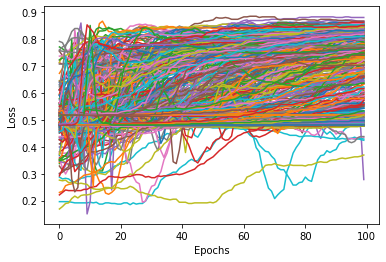

In [592]:
import matplotlib.pyplot as plt
for history in accuracies:
    epochHistory = plt.plot(history)
    epochHistory = plt.xlabel('Epochs')
    epochHistory = plt.ylabel('Loss')

plt.show()

In [593]:
final = [x[-1] for x in accuracies]

In [594]:
sorted_models = [(x, _) for _, x in sorted(zip(final, trained_models), reverse=True)]

In [595]:
print(sorted_models[-5:])
print(sorted_models[:5])

[(GeneratedModel(
  (nn_layers): ModuleList(
    (0): Linear(in_features=10, out_features=16, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=16, out_features=32, bias=True)
    (3): ReLU()
    (4): Linear(in_features=32, out_features=1, bias=True)
    (5): Sigmoid()
  )
), 0.4360730593607306), (GeneratedModel(
  (nn_layers): ModuleList(
    (0): Linear(in_features=10, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=64, out_features=1, bias=True)
    (6): Sigmoid()
  )
), 0.4292237442922374), (GeneratedModel(
  (nn_layers): ModuleList(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): Sigmoid()
    (2): Linear(in_features=8, out_features=32, bias=True)
    (3): Tanh()
    (4): Dropout(p=0.25, inplace=False)
    (5): Linear(in_features=32, out_features=1, bias=True)
    (6): Sigmoid()
  )
), 0.4246575342465753), (Generate

In [596]:
import math

tanh_av = 0
tanh_c = 0
relu_av = 0
relu_c = 0
elu_av = 0
elu_c = 0
sigmoid_av = 0
sigmoid_c = 0

node_vals = ["8", "16", "32", "64", "128", "256", "512"]
node_avgs = [0, 0, 0, 0, 0, 0, 0]
node_cs = [0, 0, 0, 0, 0, 0, 0]

for pair in sorted_models:
    model = pair[0]
    tanh = type(nn.Tanh())
    relu = type(nn.ReLU())
    elu = type(nn.ELU())
    sigmoid = type(nn.Sigmoid())
    linear = type(nn.Linear(in_features=1, out_features=1))
    #print(list(model.nn_layers)[:-2])
    for layer in list(model.nn_layers)[:-2]:
        if type(layer) == tanh:
            tanh_av += pair[1]
            tanh_c += 1
        elif type(layer) == relu:
            relu_av += pair[1]
            relu_c += 1
        elif type(layer) == elu:
            elu_av += pair[1]
            elu_c += 1
        elif type(layer) == sigmoid:
            sigmoid_av += pair[1]
            sigmoid_c += 1
        elif type(layer) == linear:
            # linear
            count = layer.out_features
            idx = int(math.log2(count)-3)
            node_avgs[idx] += pair[1]
            node_cs[idx] += 1
            
tanh_av = tanh_av / tanh_c
relu_av = relu_av / relu_c
elu_av = elu_av / elu_c
sigmoid_av = sigmoid_av / sigmoid_c

for i in range(len(node_avgs)):
    node_avgs[i] = node_avgs[i] / node_cs[i]

activation_avgs = [tanh_av, relu_av, elu_av, sigmoid_av]
activation_vals = ["TanH", "ReLU", "ELU", "Sigmoid"]

#### Visualizations

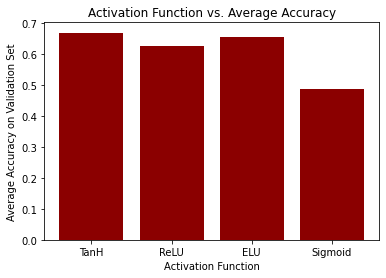

In [597]:
plt.bar(activation_vals, activation_avgs, color ='darkred')
plt.xlabel("Activation Function")
plt.ylabel("Average Accuracy on Validation Set")
plt.title("Activation Function vs. Average Accuracy")
plt.show()

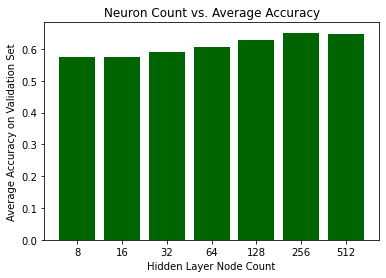

In [598]:
plt.bar(node_vals, node_avgs, color ='darkgreen')
plt.xlabel("Hidden Layer Node Count")
plt.ylabel("Average Accuracy on Validation Set")
plt.title("Neuron Count vs. Average Accuracy")
plt.show()